In [1]:
import math
import string

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction import DictVectorizer

sns.set()
%matplotlib inline

# Set seed
np.random.seed(416)

# Data preparation

We will use a dataset consisting of food product reviews on Amazon.com 

In [2]:
products = pd.read_csv('https://raw.githubusercontent.com/johnwise143/data/main/food_products.csv')
products

,product_id,summary,review,rating
0,4408,Does increase milk supply,This really helped to increase my milk supply....,3.0
1,4209,One bad packet ruins the product!,I should have stayed with Idahoan brand. Poor ...,1.0
2,8623,CAULIFLOWER PASTA!?,"As the pasta cooked, I read the box to see wha...",4.0
3,9439,Tasty and inexpensive,I really like this cereal. The flavor is sligh...,5.0
4,7110,I'm Confused,The label on the bowl says 35 grams is in the ...,2.0
...,...,...,...,...
1245,2870,10 times the price,I recently bought Domino 10 lb premium cane su...,1.0
1246,8823,Sweet & Crunchy Peanuts,While these are not the highest quality peanut...,3.0
1247,6343,Annies GF Mac Deluxe,"I had been using Annies GF Mac n Cheese, then ...",4.0
1248,5801,"OK, but Check the Pricing",Dr. Oz recommended this brand of coconut water...,3.0


## Extract sentiments

We will **ignore** all reviews with *rating = 3*, since they tend to have a neutral sentiment.

In [3]:
products = products[products['rating'] != 3]
products = products.copy()
print(len(products))

889


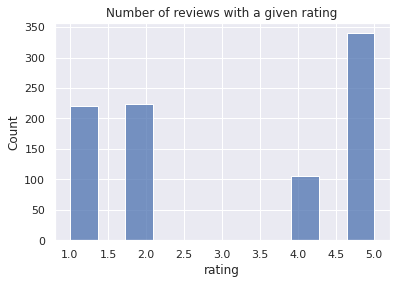

In [4]:
plt.title('Number of reviews with a given rating')
sns.histplot(products['rating'])

Now, we will assign reviews with a rating of 4 or higher to be *positive* reviews, while the ones with rating of 2 or lower are *negative*. For the sentiment column, we use +1 for the positive class label and -1 for the negative class label.

In [5]:
products['sentiment'] = products['rating'].apply(lambda rating : +1 if rating > 3 else -1)
products.head()

,product_id,summary,review,rating,sentiment
1,4209,One bad packet ruins the product!,I should have stayed with Idahoan brand. Poor ...,1.0,-1
2,8623,CAULIFLOWER PASTA!?,"As the pasta cooked, I read the box to see wha...",4.0,1
3,9439,Tasty and inexpensive,I really like this cereal. The flavor is sligh...,5.0,1
4,7110,I'm Confused,The label on the bowl says 35 grams is in the ...,2.0,-1
5,1373,Flat,Doesn't taste like ginger. Thought it would s...,2.0,-1


Now, we can see that the dataset contains an extra column called **sentiment** which is either positive (+1) or negative (-1).

## Build the word count vector for each review

Let us explore a specific example of a food product. We have information about the product, the review left, and both the rating that was given and the sentiment label we computed.

In [6]:
products.iloc[21]

product_id                                                  918
summary                                It's PRIME-arily Lobster
review        if it's primarily made from lobster, what else...
rating                                                      4.0
sentiment                                                     1
Name: 34, dtype: object

To work with the text data, we will need to eventually turn it into word counts. In other words, we will be making a feature for every word that could possibly appear in the data, and the value for that feature for one example would be the number of times that word appears in that example. 

To accomplish this, we will need to do two data transformation:

1. Remove punctuation
2. Transform the reviews into word-counts.


In [7]:
def remove_punctuation(text):
    if type(text) is str:
        return text.translate(str.maketrans('', '', string.punctuation))
    else:
        return ''
    
products['review_clean'] = products['review'].apply(remove_punctuation)

Next, we use scikit-learn's countvectorizer to get counts for each word. 

In [8]:
# Make counts
vectorizer = CountVectorizer()
count_matrix = vectorizer.fit_transform(products['review_clean'])

# Make a new DataFrame with the counts information
product_data = pd.DataFrame(count_matrix.toarray(),
        index=products.index,
        columns=vectorizer.get_feature_names_out())

# Add the old columns to our new DataFrame. 
# We won't use review_clean and the summary in our model, but we will keep
# them to look at later.
product_data['sentiment'] = products['sentiment']
product_data['review_clean'] = products['review_clean']  
product_data['summary'] = products['summary']

product_data.head()

,0000,002,004,004oz,012months,032,051,08,0f,10,...,zico1,zico3,zicos,zillion,zinger,zip,ziplock,sentiment,review_clean,summary
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,-1,I should have stayed with Idahoan brand Poor B...,One bad packet ruins the product!
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,As the pasta cooked I read the box to see what...,CAULIFLOWER PASTA!?
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,I really like this cereal The flavor is slight...,Tasty and inexpensive
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,-1,The label on the bowl says 35 grams is in the ...,I'm Confused
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,-1,Doesnt taste like ginger Thought it would sav...,Flat


We have now created a lot of features to work with! Note that in the table above, we will have one feature for each word taht appeared in the data and the value for that feature is the count of that word in that review. So for example, if review 5 had the word "dog" in it 3 times, the value in row 5 and column "dog" would be 3.

## Split data into training, validation and test sets.

Let's perform a train/validation/test split with 80% of the data in the training set, 10% of the data in the validation set, 10% test.

In [9]:
train_data, test_data = train_test_split(product_data, test_size=0.2)
validation_data, test_data = train_test_split(test_data, test_size=0.5)

# Baseline: Majority class prediction

It is quite common to use the **majority class classifier** as the a baseline (or reference) model for comparison with your classifier model. The majority classifier model predicts the majority class for all data points.

To "train" the majority class classifier, you should simply find the most frequent target in the training data.

### **Question 1:** Majority class classifier
* Compute the most frequent label and store it in a variable called `majority_label`.
* What is the validation accuracy of the majority class classifer. Store your result as a number between 0 and 1 in a variable called `majority_classifier_validation_accuracy`.
  
  *Hint:* pandas allows you to take the sum of a boolean series - true values are equal to 1, false values are equal 0.

In [10]:
### edTest(test_q1_majority_classifier) ###

# TODO "Train" a majority class classifier and calculate its validation accuracy
n = product_data.size
n_positive = product_data[product_data['sentiment'] == 1].size
majority_label = -1 if n > n_positive else 1

n_val = validation_data.size
n_val_correct = validation_data[validation_data['sentiment'] == majority_label].size
majority_classifier_validation_accuracy = n_val_correct / n_val
# print(majority_classifier_validation_accuracy)

# Train a sentiment classifier with logistic regression

We will now use logistic regression to create a sentiment classifier on the training data. This model will use the columns representing word coutnts as features and the column **sentiment** as the target. We will set **no regularization penalty**.

You can see scikit-learn's documentation for LogisticRegression [here](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html). Note that the parameter for this class to control regularization is named `C` and it represents the inverse of the penalty strenght. In other words $C = \frac{1}{\lambda}$. This means to have very little regularization, we make `C` a very large number (corresponding to a very small $\lambda$).

In [11]:
features = vectorizer.get_feature_names_out()

# Note: C = 1/Lambda. Setting C to a really high value is the same as setting lambda = 0
sentiment_model = LogisticRegression(penalty='l2', C=1e23)
sentiment_model.fit(train_data[features], train_data['sentiment'])

LogisticRegression(C=1e+23)

Let's look at some of the coefficients and the corresponding words. The weights are stored in a `coef_` property: 

In [12]:
coefficients = sentiment_model.coef_[0] 

print('Smallest coefficient', coefficients.min())
print('Largest coefficient:', coefficients.max())

Smallest coefficient -12.061144888132606
Largest coefficient: 18.070453817504884


### **Question 2:** Most Positive/Negative Word
For the sentiment model we trained above, compute the word with the most negative weight and the word with the most positive weight.

Store your results in the variables `most_negative_word` and `most_positive_word`.

While you only need to write code to compute the most negative and most positive, we also recommend printing out the words with the highest magnitude coefficients to make sure they make sense.


In [13]:
### edTest(test_q2_most_pos_neg_words) ###

# TODO Find the most positive word and most negative word in the sentiment_model
min_index = np.where(coefficients == coefficients.min())
max_index = np.where(coefficients == coefficients.max())

features = sentiment_model.feature_names_in_
most_negative_word = features[min_index][0]
most_positive_word = features[max_index][0]

In [14]:
print('Most negative word:', most_negative_word)
print('Most positive word:', most_positive_word)

Most negative word: not
Most positive word: great


## Making predictions with logistic regression

Now that a model is trained, we can make predictions on the **validation data**. In this first section, we will restrict the examples we are looking at to 3 examples in the validation dataset. We refer to this set of 3 examples as the **sample_data**.

In [15]:
sample_data = validation_data[8:11]
sample_data[['sentiment', 'review_clean', 'summary']]

,sentiment,review_clean,summary
814,-1,If you want a real ginger chew buy Gin Gins T...,These taste like nothing
829,-1,This water is disgusting and tastes like anoth...,GROSS! TASTES LIKE STALE BREAD
1053,1,For the hatersseriously Protein bars never ta...,Pretty good for a protein bar


### Predicting sentiment
Let's start by predicting the sentiment of the 3 examples in the `sample_data`. The `predict_proba` method on the `LogisticRegression` class outputs a probability for each class possible.

The output has one row for each example. Each row is an array of 2 numbers, the first is the predictor's prediction for the probability it is a negative sentiment example, and the second is the probability of it being a positive sentiment example.

In [16]:
print('  Prob Negative, Prob Positive')
print(sentiment_model.predict_proba(sample_data[features]))

  Prob Negative, Prob Positive
[[1.00000000e+00 2.44027092e-11]
 [9.14779239e-01 8.52207609e-02]
 [1.00000000e+00 5.22523623e-13]]


We are also able to make predictions using the `predict` function

In [17]:
print('Predicted labels')
print(sentiment_model.predict(sample_data[features]))

Predicted labels
[-1 -1 -1]


### **Question 3:** Find the most positive (and negative) review

We now turn to examining the full **validation_data** dataset <span style="color:red">(not sample_data)</span>, , and use `sklearn` to form predictions on all of the data points for faster performance.

Using the `sentiment_model`, find review in the **validation_data** with the **highest probability** of being classified as a **positive review**. Also, find the reivew with the **highest probability** of being classified as a **negative review**. We refer to these as the "most positive review" and "most negative review" respectively. Store the `review_clean` column value for each of these rows in `most_positive_review` and `most_negative_review` respectively.

If there is a tie for the most positive/negative reivew, you should always grab the one that appears *first* in the validation data.

*Hint*: Once you know the index of the most positive/negative reviews, use the `.iloc[]` accessor on the DataFrame to get that row and find its `review_clean` value.

In [18]:
### edTest(test_q3_most_positive_negative_review) ###

# TODO Find the review_clean values for the most positive and most negative review
val_pred = sentiment_model.predict_proba(validation_data[features])
val_negatives = np.array([x[0] for x in val_pred])
val_positives = np.array([x[1] for x in val_pred])
max_negative = np.max(val_negatives)
max_positive = np.max(val_positives)
val_max_negative_i = np.where(val_negatives == max_negative)[0][0]
val_max_positive_i = np.where(val_positives == max_positive)[0][0]

most_negative_review = validation_data.iloc[val_max_negative_i]['review_clean']
most_positive_review = validation_data.iloc[val_max_positive_i]['review_clean']

In [19]:
print('Most Positive Review:')
print(most_positive_review)
print()
print('Most Negative Review:')
print(most_negative_review)

Most Positive Review:
My Favorite KnorrLipton Flavor of all the Sides This flavor with the cheddar and broccoli is so so so good And love the fact that it tastes so cheesy and also has broccoli in it This makes a quick meal for one or two For me I eat it as a regular meal and eat the whole package by myself as it is that goodHighly recommend this product

Most Negative Review:
This review is for the Chocolate Fudge flavor of the Think Thin Bars  In a word yuck  This bar may be all kinds of nutritious but you have to want to eat it for that to take any effectThe taste and texture was kind of like eating cocoa powder dusted Styrofoam  It was kind of chewy and soft all at the same time and the only flavor aside from a dry flat taste was the cocoa powder  And it was more like a milk chocolate for the cocoa powder as it had that kind of sour aftertaste  Needless to say I didnt enjoy itThe ingredients are decent  The following is the ingredients list copied from Think Thins websitePROTEIN BL

Do you notice something special about those reviews? They are both pretty long! Here we just count number of words regardless of the length of the review but clearly that can affect the results, and in practice one can use some techniques to normalize the counts to avoid prioritizing long reviews over shorter ones (we will discuss this idea in a future week).

### **Question 4:** Compute validation accuracy
Compute the validation accuracy for the model we just trained. Report the validationaccuracy as a number between 0 and 1 stored in a variable called `sentiment_model_validation_accuracy`.

Below, calculate the accuracy of the predictor using sklearn's accuracy score function.

In [20]:
### edTest(test_q4_sentiment_model_accuracy) ###
from sklearn.metrics import accuracy_score
# TODO Find the validation accuracy of the sentiment model
val_pred = sentiment_model.predict(validation_data[features])
sentiment_model_validation_accuracy = accuracy_score(validation_data['sentiment'], val_pred)
# print(sentiment_model_validation_accuracy)

# Create a confusion matrix

A common tool used when analyzing the peformance of a predictor in a classification problem is to look at the confusion matrix, as well as the overall accuracy.

We've created a function that will plot a confusion matrix for you given a set of inputs which are the values that should appear within each cell.
Recall that there are four values associated with a confusion matrix: true positive, true negative, false positive, and false negative which we will abberviate as TP, TN, FP, and FN, respecitvely. In other words, for the next problem we have handled the plotting code for you that you can use, but you will need to compute the values for each of the confusion matrix dimensions.

In [21]:
def plot_confusion_matrix(tp, fp, fn, tn):
    """
    Plots a confusion matrix using the values 
       tp - True Positive
       fp - False Positive
       fn - False Negative
       tn - True Negative
    """
    data = np.matrix([[tp, fp], [fn, tn]])

    sns.heatmap(data,annot=True,xticklabels=['Actual Pos', 'Actual Neg']
              ,yticklabels=['Pred. Pos', 'Pred. Neg']) 

### **Question 5:** Compute confusion matrix values and plot

Write code below that uses the `plot_confusion_matrix` function to show the number of true positive, true negative, false positive, and false negative predictions made by your classifier. You should store the counts for each of these values in the variables:
* `tp`
* `fp`
* `fn`
* `tn` 

You might find it useful to use named parameters here (i.e. you can call `plot_confusion_matrix(tp=X, fp=Y, fn=A, tn=B)` instead of having to get the order of the parameters correct)

In [22]:
### edTest(test_q5_confusion_matrix) ###

# TODO Compute the four values tp, fp, fn, tn and plot them using plot_confusion_matrix
validation_data['predicted'] = val_pred
tp = validation_data[(validation_data['sentiment'] == 1) & (validation_data['predicted'] == 1)].size
fp = validation_data[(validation_data['sentiment'] == -1) & (validation_data['predicted'] == 1)].size
tn = validation_data[(validation_data['sentiment'] == -1) & (validation_data['predicted'] == -1)].size
fn = validation_data[(validation_data['sentiment'] == 1) & (validation_data['predicted'] == -1)].size

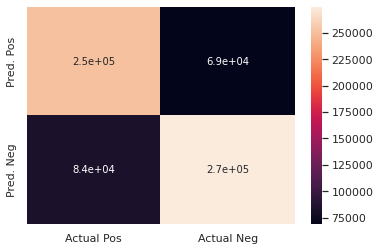

In [23]:
plot_confusion_matrix(tp=tp, fp=fp, tn=tn, fn=fn)

## **Question 6 and 7**: Logistic Regression with L2 regularization

One of the challenges of creating features from each word is that there are many more features than observations. It is easy to overfit. We will explore the effect of the regularization in this problem.

Now that we have written up all the pieces needed for regularized logistic regression, let's explore the benefits of using **L2 regularization** in analyzing sentiment for product reviews. 

Like in the last assignment, we will train models with various levels of regularization starting with a small amount and then moving to a  large amount. The code here will have some similarities to the code you did in the last assignment, so you will find that to be a useful reference, but this problem will be slightly more complex since we ask you to compute a few values.

This code will be counted as two separate questions since you will be computing slightly different values, but we will ask you to compute both of them in the same starter code to reduce code duplication (since the tasks are very similar). 

We first outline what you should compute for each question and then show some general implementation notes for both problems below. Your task for this problem is to fill out the code inside the loop to compute the values described below.

We recommend focusing on the value you need to compute for Q7 and then once you have that working work on the code you need to compute Q8.

### **Question 6:** Coefficient Paths`
For this question we will ask you to compute the coefficent path for each of the features in the model for various values of the regularization constant.

For each regularization strength, train a model using that regularization constant and compute table storing the coefficients of each learned predictor. Store the results in a `DataFrame` named `coef_table`.

You should end up with an `DataFrame` with column names as `'coefficients \[L2=1e-02\]', ... 'coefficients \[L2=1e+05\]'`, and a row for each word in `features`. 

Before the loop, we set up `coef_table` to have the right rows and columns, but your code will need to fill out the rest.

### **Question 7:** Train and Validation Accuracies
Similar to Q6, we want you to compute the training and validation accuracy for each learned predictor and store that in a `DataFrame` called `accuracies_table`. 

You should end up with a `DataFrame` with column names `'l2_penalty', 'train_accuracy', 'validation_accuracy'` and a row for each L2 penalty tried. The L2 penaly should be the number (not the column name from Q7) and the accuracy values should be numbers between 0 and 1 for the appropriate accuracy.

For this problem, we recommend the approach used in HW2 to build up a list of dictionaries, and then convert that to a `DataFrame` with the values described.

### Implementation Details

Some important notes about your implementation:
* When constructing a `LogisticRegression` object, avoid having an intercept term in this example, so pass `fit_intercept=False` when constructing the `LogisticRegression` model.
* <span style="color:red">When constructing the LogisticRegression(...) model, the parameter `C` is the **inverse** of the L2 penalty (1 / L2_penalty). </span>
* Q7: To store the results of your predictor's coefficients, you will need to get the values from the `.coef_` property. Since the code for this is a little complex, we give you this line below (assumes your trained model is stored in a variable called `model`):
  ```
  coef_table[column_name] = model.coef_[0]
  ```

  Confusingly this grabs all the coefficients and treats them like a list of numbers rather than the 2D array of rows/columns that scikit-learn originally provides.

* It is okay if your code prints `ConvergenceWarnings`. This is something you would want to avoid in practice but is okay in our assignment for simplicity.

* We recommend just focusing on Q6 at first and getting the code to set up the coefficients table right. Then once that's working, evaluate the models for Q7.


In [24]:
### edTest(test_q6_q7_train_models) ###

# TODO Fill in the loop below

# Set up the regularization penalities to try
l2_penalties = [0.01, 1, 4, 10, 1e2, 1e3, 1e5]
l2_penalty_names = [f'coefficients [L2={l2_penalty:.0e}]' 
                    for l2_penalty in l2_penalties]

# Q6: Add the coefficients to this coef_table for each model
coef_table = pd.DataFrame(columns=['word'] + l2_penalty_names)
coef_table['word'] = features

# Q7: Set up an empty list to store the accuracies (will convert to DataFrame after loop)
accuracy_data = []

for l2_penalty, l2_penalty_column_name in zip(l2_penalties, l2_penalty_names):
    # TODO(Q6 and Q7): Train the model 
    model = LogisticRegression(C=(1/l2_penalty))
    model.fit(train_data[features], train_data['sentiment'])
    
    # TODO(Q6): Save the coefficients in coef_table
    coef_table[l2_penalty_column_name] = model.coef_[0]
    
    # TODO(Q7): Calculate and save the train and validation accuracies
    train_pred = model.predict(train_data[features])
    train_acc = accuracy_score(train_data['sentiment'], train_pred)
    val_pred = model.predict(validation_data[features])
    val_acc = accuracy_score(validation_data['sentiment'], val_pred)
    accuracy_data.append({
        'l2_penalty': l2_penalty,
        'train_accuracy': train_acc,
        'validation_accuracy': val_acc
    })

accuracies_table = pd.DataFrame(accuracy_data)

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [25]:
# Look at coef_table
coef_table

,word,coefficients [L2=1e-02],coefficients [L2=1e+00],coefficients [L2=4e+00],coefficients [L2=1e+01],coefficients [L2=1e+02],coefficients [L2=1e+03],coefficients [L2=1e+05]
0,0000,0.053218,0.022410,0.014442,0.009909,0.002686,0.000431,0.000005
1,002,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,004,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,004oz,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,012months,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...
7620,zicos,-0.193506,-0.078904,-0.044725,-0.026304,-0.004382,-0.000486,-0.000005
7621,zillion,-0.103889,-0.049935,-0.032991,-0.021975,-0.004372,-0.000514,-0.000005
7622,zinger,-0.087445,-0.027026,-0.012431,-0.006030,-0.000313,0.000297,0.000005
7623,zip,0.189326,0.091640,0.059909,0.040648,0.009602,0.001419,0.000015


In [26]:
# Look at accuracies_table
accuracies_table

,l2_penalty,train_accuracy,validation_accuracy
0,0.01,1.000000,0.820225
1,1.00,1.000000,0.797753
2,4.00,0.994374,0.808989
3,10.00,0.981716,0.764045
4,100.00,0.869198,0.730337
5,1000.00,0.696203,0.617978
6,100000.00,0.517581,0.550562


## **Question 8:** Inspect Coefficients

We'll now look at the **coefficients** for the model that were trained above. We will create a table of features and learned coefficients associated with each of the different L2 penalty values.

Using **the coefficients trained with L2 penalty 1**, find the 5 most positive words (with largest positive coefficients). Save them to `positive_words`. Similarly, find the 5 most negative words (with largest negative coefficients) and save them to `negative_words`. The result should be the `'word'` column for the these rows. 

To be specific, the type of the value we are looking for is a `Series` in `pandas` which is the type of a single row or column in a `DataFrame`. When you have a `DataFrame`, it is a structure with rows and columns. When you access a single column as in `df[column_name]`, this returns a `Series` representing that one column. 

This means your result for each one of these variables should be a `Series` of length 5 for the respective words.


*Hint:* You can use the `.nlargest()` and `.nsmallest()` method on an DataFrame to find the top `n` rows sorted according to the value of a specified column.

In [27]:
### edTest(test_q8_most_positive_negative) ###


# TODO Compute words with the 5 largest coefficients and 5 smallest coefficients
l2p1_name = 'coefficients [L2=1e+00]'
positive_words = pd.Series(coef_table.nlargest(5, l2p1_name)['word'])
negative_words = pd.Series(coef_table.nsmallest(5, l2p1_name)['word'])

In [28]:
print(positive_words)
print(negative_words)

3096    great
2858    fresh
863      best
2679     find
1920      day
Name: word, dtype: object
4586       not
7497      wont
2938      gave
694       away
6703    tastes
Name: word, dtype: object


Let us observe the effect of increasing L2 penalty on the 10 words just selected. We provide you with a utility function to  plot the coefficient path.

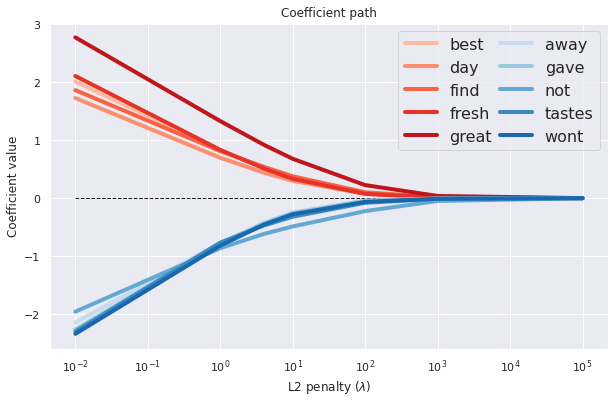

In [29]:
def make_coefficient_plot(table, positive_words, negative_words, l2_penalty_list):
    def get_cmap_value(cmap, i, total_words):
        """
        Computes a nice scaling of from i=0 to i=total_words - 1
        for the given cmap
        """
        return cmap(0.8 * ((i + 1) / (total_words * 1.2) + 0.15))


    def plot_coeffs_for_words(ax, words, cmap):
        """
        Given an axes to plot on and a list of words and a cmap,
        plots the coefficient paths for each word in words
        """
        words_df = table[table['word'].isin(words)]
        words_df = words_df.reset_index(drop=True)  # To make indices sequential

        for i, row in words_df.iterrows():
            color = get_cmap_value(cmap, i, len(words))
            ax.plot(xx, row[row.index != 'word'], '-',
                    label=row['word'], linewidth=4.0, color=color)

    # Make a canvas to draw on
    fig, ax = plt.subplots(1, figsize=(10, 6))
   
    # Set up the xs to plot and draw a line for y=0
    xx = l2_penalty_list
    ax.plot(xx, [0.] * len(xx), '--', linewidth=1, color='k')

    # Plot the positive and negative coefficient paths
    cmap_positive = plt.get_cmap('Reds')
    cmap_negative = plt.get_cmap('Blues')
    plot_coeffs_for_words(ax, positive_words, cmap_positive)
    plot_coeffs_for_words(ax, negative_words, cmap_negative)

    # Set up axis labels, scale, and legend  
    ax.legend(loc='best', ncol=2, prop={'size':16}, columnspacing=0.5 )
    ax.set_title('Coefficient path')
    ax.set_xlabel('L2 penalty ($\lambda$)')
    ax.set_ylabel('Coefficient value')
    ax.set_xscale('log')


make_coefficient_plot(coef_table, positive_words, negative_words, l2_penalty_list=l2_penalties)